In [1]:
import pathlib

import matplotlib
import numpy
import pandas
import seaborn

seaborn.set_theme(
    style='darkgrid',
    palette='colorblind',
    rc={'figure.figsize': (8, 4)},
)

data location:

In [2]:
# a smaller samples for preview:
#amd64_results_path = pathlib.Path('amd/results/1610234413/')
#arm64_results_path = pathlib.Path('arm/results/1610234462/')

amd64_results_path = pathlib.Path('amd64/1610236849')
arm64_results_path = pathlib.Path('arm64/1610236845')

hue_order = ('amd64', 'arm64')

# General setup

We decided to compare MySQL performance on `m5.4xlarge` with Intel CPU and new Graviton2-powered `m6.4xlarge`. Both machines have about 64G RAM and 16 vCPUs. We also attached 1T `gp2` volume to each of them.

We also launched 2 `c5` instances on AWS for `sysbench` connecting them to server machines via VPC.

All machines were running Ubuntu 20.04 LTS. Both servers were rebooted after initial `sysbench prepare`.

# MySQL config

We used mysql-server binaries provided by Canonical:

```bash
apt install mysql-server --no-install-recommends
```

We adjusted these variables:

```ini
[mysqld]
ssl=0
performance_schema=OFF
skip_log_bin
general_log=OFF
innodb_buffer_pool_size=48G
table_open_cache = 200000
table_open_cache_instances=64
back_log=3500
max_connections=4000
join_buffer_size=256K
sort_buffer_size=256K
```

Just in case - check if `my.cnf` is the same on arm and x86 machines

In [3]:
!diff --suppress-common-lines --side-by-side --color=always \
    $amd64_results_path/sql-variables.mysql \
    $arm64_results_path/sql-variables.mysql | grep -v -E '/mnt/|uuid'

bind_address	0.0.0.0					      |	bind_address	here.local
hostname	mysql-amd64-31-37-20			      |	hostname	mysql-arm64-31-36-62
relay_log	mysql-amd64-31-37-20-relay-bin		      |	relay_log	mysql-arm64-31-36-62-relay-bin
timestamp	1610236852.846979			      |	timestamp	1610236848.800796
version_compile_machine	x86_64				      |	version_compile_machine	aarch64


# `sysbench` setup

We ran 

```bash
sysbench oltp_read_only.lua \
    --report-interval=1 \
    --rand-type=uniform --rand-seed=162412019 \
    --tables=10 --table_size=10000000 \
    --threads=... <mysql connection params> \
    run | sed -E 's/^([^0-9#])/#\1/g' | \ tee -a <output_file>
 ```

with different number of threads,
where `oltp_read_only.lua` is a modified version of `oltp_read_only` with the only change: reporting hook set to CSV.

In [4]:
!grep SYSBENCH $amd64_results_path/env.sysbench #!@#

In [5]:
!diff --suppress-common-lines --side-by-side --color=always \
    $amd64_results_path/env.sysbench \
    $arm64_results_path/env.sysbench | grep -v -i -E 'ssh|session|tmux'

TERM=xterm-256color					      |	TERM=screen-256color


In [6]:
!diff --suppress-common-lines --side-by-side --color=always \
    $amd64_results_path/sql-status.mysql \
    $arm64_results_path/sql-status.mysql

Uptime:			7 min 52 sec			      |	Uptime:			6 min 55 sec
Threads: 2  Questions: 12  Slow queries: 0  Opens: 116  Flush |	Threads: 2  Questions: 12  Slow queries: 0  Opens: 116  Flush


In [7]:
!diff --suppress-common-lines --side-by-side --color=always \
    $amd64_results_path/sql-version.mysql \
    $arm64_results_path/sql-version.mysql

Machines' memory configurations are slightly different:

In [8]:
!diff --suppress-common-lines --side-by-side --color=always \
    $amd64_results_path/numa-hardware.mysql \
    $arm64_results_path/numa-hardware.mysql

node 0 size: 63523 MB					      |	node 0 size: 62918 MB
node 0 free: 43781 MB					      |	node 0 free: 43247 MB


In [9]:
!diff --suppress-common-lines --side-by-side --color=always \
    $amd64_results_path/config.sysbench \
    $arm64_results_path/config.sysbench

Kernels differ radically of course

In [10]:
!diff --suppress-common-lines --side-by-side --color=always \
    $amd64_results_path/config.mysql \
    $arm64_results_path/config.mysql | \
   grep -E -v -i 'arch|x86|arm|amd' | wc -l

4192


Not much information about the Graviton2 in `/proc/cpuinfo`:

In [11]:
!diff --suppress-common-lines --side-by-side --color=always \
    $amd64_results_path/cpuinfo.mysql \
    $arm64_results_path/cpuinfo.mysql | awk '!x[$0]++'

vendor_id	: GenuineIntel				      |	BogoMIPS	: 243.75
cpu family	: 6					      |	Features	: fp asimd evtstrm aes pmull sha1 sha2 crc32 
model		: 85					      |	CPU implementer	: 0x41
model name	: Intel(R) Xeon(R) Platinum 8259CL CPU @ 2.50 |	CPU architecture: 8
stepping	: 7					      |	CPU variant	: 0x3
microcode	: 0x5002f01				      |	CPU part	: 0xd0c
cpu MHz		: 3100.033				      |	CPU revision	: 1
cache size	: 36608 KB				      <
physical id	: 0					      <
siblings	: 16					      <
core id		: 0					      <
cpu cores	: 8					      <
apicid		: 0					      <
initial apicid	: 0					      <
fpu		: yes					      <
fpu_exception	: yes					      <
cpuid level	: 13					      <
wp		: yes					      <
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep <
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_sto <
bogomips	: 5000.00				      <
clflush size	: 64					      <
cache_alignment	: 64					      <
address sizes	: 46 bits physical, 48 bits virtual	      <
power management:					      <
vendor_i

More things to compare later maybe:

In [12]:
ls $amd64_results_path $arm64_results_path

amd64/1610236849:
config.mysql                       result.oltp_read_only.threads030/
config.sysbench                    result.oltp_read_only.threads040/
cpuinfo.mysql                      result.oltp_read_only.threads050/
cpuinfo.sysbench                   result.oltp_read_only.threads060/
env.sysbench                       result.oltp_read_only.threads070/
hostname.mysql                     result.oltp_read_only.threads080/
hostname.sysbench                  result.oltp_read_only.threads090/
information_schema_tables/         result.oltp_read_only.threads100/
ldconfig.mysql                     result.oltp_read_only.threads110/
ldconfig.sysbench                  result.oltp_read_only.threads120/
lsb_release.mysql                  result.oltp_read_only.threads130/
lsb_release.sysbench               result.oltp_read_only.threads140/
meminfo.mysql                      result.oltp_read_only.threads150/
meminfo.sysbench                   sql-status.mysql
mysql-client.version.sysbench    

Discover all the cases:

In [13]:
amd64_results_per_threads_path = {
    tuple(
        suffix.lstrip('.')
        for suffix in path.suffixes
    ): path
    for path in amd64_results_path.glob('result.*.threads*')
}
arm64_results_per_threads_path = {
    tuple(
        suffix.lstrip('.')
        for suffix in path.suffixes
    ): path
    for path in arm64_results_path.glob('result.*.threads*')
}

cases = (
    ('amd64', amd64_results_path, amd64_results_per_threads_path),
    ('arm64', arm64_results_path, arm64_results_per_threads_path),
)

Load the data:

In [14]:
df = None
comments = {}
suite_info = {}

for case, top_path, raw_results in cases:
    suite_info[case] = {}
    suite_info[case]['start'] = int(top_path.stem)
    suite_info[case]['env'] = dict(
        line.split('=', 1)
        for line in
        (top_path / 'env.sysbench').read_text().rstrip().split('\n')
    )
    for name in ('meminfo.mysql', 'meminfo.sysbench'):
        suite_info[case][name] = pandas.Series({
            (
                s:=line.split(maxsplit=1
            ))[0].rstrip(':'): int(s[1].split(maxsplit=1)[0])
            for line in (top_path / name).read_text().rstrip().split('\n')
        })
    for name in ('hostname.mysql', 'hostname.sysbench',
                 'mysql-client.version.sysbench',
                 'version.sysbench',
                 'uname.mysql', 'uname.sysbench'):
        suite_info[case][name] = (top_path / name).read_text().strip()

    for (test_name, threads), path in raw_results.items():
        df_part = pandas.read_csv(
            path / 'output.txt',
            header=None,
            names=['seconds', 'threads', 'events_rate',
                   'rate', 'reads_rate', 'writes_rate', 'other_rate',
                   'latency', 'errors_rate', 'reconnects_rate'],
            dtype={'seconds': 'UInt32', 'threads_running': 'UInt16'},
            comment='#',
        )
        df_part['test_name'] = test_name
        df_part['test_name'] = df_part['test_name'].astype('category')
        df_part['case'] = case
        df_part['case'] = df_part['case'].astype('category')
        df_part.set_index(['test_name', 'case',
                           'threads', 'seconds'], inplace=True)
        df_part.columns.name = 'metric'

        if df is None:
            df = df_part
        else:
            df = pandas.concat((df, df_part))

        start = int((path / 'start.timestamp').read_text().strip())
        finish = int((path / 'finish.timestamp').read_text().strip())

        comments_test = comments.setdefault(
            test_name, {},
        ).setdefault(
            case, {},
        ).setdefault('threads', [])
    
        index = 'info'
        index2 = ''
        with (path / 'output.txt').open() as fobj:
            for line in fobj:
                if not line.startswith('#'):
                    continue
                group = tuple(
                    s.rstrip() if i == 0 else tuple(
                        s.strip().split('/')
                        if '/' in s else
                        s.strip().split(maxsplit=1)
                    )
                    for i, s in enumerate(
                        line.lstrip('#').rstrip().split(':')
                    )
                )
                comments_test.append(group)

In [15]:
columns = ['events_rate', 'reads_rate', 'other_rate', 'latency']

pandas.DataFrame(suite_info)

,amd64,arm64
start,1610236849,1610236845
env,"{'SHELL': '/bin/bash', 'TMUX': '/tmp/tmux-1000...","{'SHELL': '/bin/bash', 'TMUX': '/tmp//tmux-100..."
meminfo.mysql,MemTotal 65048080 MemFree ...,MemTotal 64428044 MemFree ...
meminfo.sysbench,MemTotal 7792732 MemFree ...,MemTotal 7850076 MemFree ...
hostname.mysql,mysql-amd64-31-37-20,mysql-arm64-31-36-62
hostname.sysbench,sysbench-v5-31-42-72,sysbench-v6-31-40-25
mysql-client.version.sysbench,mysql Ver 8.0.22-0ubuntu0.20.04.3 for Linux o...,mysql Ver 8.0.22-0ubuntu0.20.04.3 for Linux o...
version.sysbench,sysbench 1.0.18,sysbench 1.0.18
uname.mysql,Linux version 5.4.0-1035-aws (buildd@lgw01-amd...,Linux version 5.4.0-1035-aws (buildd@bos02-arm...
uname.sysbench,Linux version 5.4.0-1029-aws (buildd@lcy01-amd...,Linux version 5.4.0-1029-aws (buildd@lcy01-amd...


In [16]:
df.head()

metric                                events_rate     rate  reads_rate  \
test_name      case  threads seconds                                     
oltp_read_only amd64 1       1             176.69  2129.29     1774.90   
                             2             199.07  2389.82     1991.68   
                             3             202.99  2427.90     2021.91   
                             4             200.00  2403.03     2003.02   
                             5             207.00  2480.04     2066.03   

metric                                writes_rate  other_rate  latency  \
test_name      case  threads seconds                                     
oltp_read_only amd64 1       1                0.0      354.38     8.58   
                             2                0.0      398.14     6.55   
                             3                0.0      405.98     6.55   
                             4                0.0      400.00     6.43   
                             5                0.0      414.01     6.55   

metric                                errors_rate  reconnects_rate  
test_name      case  threads seconds                                
oltp_read_only amd64 1       1                0.0              0.0  
                             2                0.0              0.0  
                             3                0.0              0.0  
                             4                0.0              0.0  
                             5                0.0              0.0

In [17]:
df.xs('amd64', level='case').describe()

metric,events_rate,rate,reads_rate,writes_rate,other_rate,latency,errors_rate,reconnects_rate
count,61199.000000,61199.000000,61199.000000,61199.0,61199.000000,61199.000000,61199.0,61199.0
mean,13365.045401,160380.652655,133650.544181,0.0,26730.108460,5.808857,0.0,0.0
std,5181.220248,62174.656859,51812.214497,0.0,10362.444479,3.306830,0.0,0.0
min,149.000000,1789.010000,1491.010000,0.0,298.000000,1.470000,0.0,0.0
25%,12856.345000,154275.675000,128563.910000,0.0,25712.550000,2.570000,0.0,0.0
50%,16002.730000,192027.850000,160024.630000,0.0,32005.140000,5.370000,0.0,0.0
75%,16565.515000,198787.785000,165656.235000,0.0,33131.255000,8.280000,0.0,0.0
max,17461.380000,209544.610000,174619.840000,0.0,34924.770000,24.830000,0.0,0.0


In [18]:
df.xs('arm64', level='case').describe()

metric,events_rate,rate,reads_rate,writes_rate,other_rate,latency,errors_rate,reconnects_rate
count,61199.000000,61199.000000,61199.000000,61199.0,61199.000000,61199.000000,61199.0,61199.0
mean,14579.070209,174948.950851,145790.792389,0.0,29158.158410,5.518189,0.0,0.0
std,5174.436073,62093.244609,51744.370726,0.0,10348.876075,3.222651,0.0,0.0
min,161.730000,1942.800000,1618.330000,0.0,324.470000,1.080000,0.0,0.0
25%,14750.420000,177009.860000,147506.300000,0.0,29501.650000,2.710000,0.0,0.0
50%,17058.730000,204702.580000,170586.650000,0.0,34117.360000,5.280000,0.0,0.0
75%,17691.755000,212292.920000,176913.255000,0.0,35382.515000,7.840000,0.0,0.0
max,19972.140000,239638.690000,199690.410000,0.0,39948.280000,15.550000,0.0,0.0


In [19]:
stacked=df.stack().reorder_levels(['metric', 'test_name', 'case', 'threads', 'seconds'])
stacked.name='value'

data = stacked[columns].reset_index()

data.head()

,metric,test_name,case,threads,seconds,value
0,events_rate,oltp_read_only,amd64,1,1,176.69
1,events_rate,oltp_read_only,amd64,1,2,199.07
2,events_rate,oltp_read_only,amd64,1,3,202.99
3,events_rate,oltp_read_only,amd64,1,4,200.00
4,events_rate,oltp_read_only,amd64,1,5,207.00


In [20]:
amd64_to_arm64 = df.xs('amd64', level='case') / df.xs('arm64', level='case')
arm64_to_amd64 = df.xs('arm64', level='case') / df.xs('amd64', level='case')

# Direct comparison

In [21]:
amd64_to_arm64[columns].aggregate(['mean', 'median']) * 100 - 100

,events_rate,reads_rate,other_rate,latency
mean,-10.89715,-10.897147,-10.897147,8.952129
median,-6.68069,-6.679179,-6.679699,5.525362


So, amd64 machines showed 11% worse througput and query rate on average in our tests (median: up to 6.7%). While latency was 9% higher (median: +5.5%).

In [22]:
arm64_to_amd64[columns].aggregate(['mean', 'median']) * 100 - 100

,events_rate,reads_rate,other_rate,latency
mean,13.362107,13.362091,13.36210,-7.113081
median,7.158958,7.157223,7.15782,-5.236052


In other words, arm64 machines showed 13.4% better thougput and query rates on average (+7.2% median) with latency being 7.1% better (median: 5.2%).

Per experiment (per thread):

In [23]:
arm64_to_amd64[columns].groupby('threads').aggregate(['mean', 'median']) * 100 - 100

events_rate            reads_rate            other_rate             \
               mean     median       mean     median       mean     median   
threads                                                                      
1         31.990822  32.810425  31.990795  32.832346  31.990830  32.820715   
5         35.832648  35.903309  35.832600  35.898231  35.832644  35.896789   
10        38.236429  38.297116  38.236392  38.298400  38.236419  38.302695   
20        28.461579  28.443339  28.461565  28.443827  28.461569  28.442511   
30        14.600866  14.752820  14.600856  14.749920  14.600860  14.750897   
40        12.857291  12.949611  12.857274  12.945703  12.857282  12.946763   
50        10.106103  10.051468  10.106107  10.054872  10.106097  10.049559   
60         6.887311   6.909579   6.887304   6.909099   6.887307   6.910891   
70         6.691512   6.637399   6.691503   6.639039   6.691507   6.638430   
80         7.638419   7.600364   7.638411   7.598385   7.638414   7.601881   
90         5.880960   5.797019   5.880957   5.790697   5.880951   5.792204   
100        5.520819   5.350114   5.520800   5.353581   5.520816   5.349116   
110        5.506327   5.307158   5.506336   5.300200   5.506324   5.304515   
120        5.510640   5.385607   5.510615   5.378549   5.510631   5.380219   
130        4.127521   3.891762   4.127513   3.893929   4.127518   3.892730   
140        3.547255   3.407809   3.547226   3.410765   3.547240   3.408223   
150        3.764488   3.618621   3.764461   3.610911   3.764474   3.616241   

           latency             
              mean     median  
threads                        
1       -23.663148 -24.844720  
5       -25.363190 -25.139665  
10      -24.468089 -24.000000  
20      -13.063214 -13.043478  
30        6.070800   5.447471  
40       -1.721089  -1.916933  
50       -7.758079  -7.070707  
60        5.821513   5.567929  
70       -0.482083   0.000000  
80       -3.134399  -3.571429  
90       -2.067219  -1.736614  
100      -6.256044  -6.883117  
110      -6.035347  -5.314010  
120      -5.318738  -5.206074  
130      -6.251447  -5.252725  
140      -1.962962  -1.779359  
150      -5.274238  -5.236052

Situation is a little bit better for x86_64 machine when sysbench is using more threads:

In [24]:
arm64_to_amd64[columns].query('threads > 50').aggregate(['mean', 'median']) * 100 - 100

,events_rate,reads_rate,other_rate,latency
mean,5.507525,5.507512,5.507518,-3.096097
median,5.554674,5.553593,5.554420,-3.672788


In [25]:
arm64_to_amd64[columns].query('threads > 50').groupby('threads').aggregate(['mean', 'median']) * 100 - 100

events_rate           reads_rate           other_rate            \
               mean    median       mean    median       mean    median   
threads                                                                   
60         6.887311  6.909579   6.887304  6.909099   6.887307  6.910891   
70         6.691512  6.637399   6.691503  6.639039   6.691507  6.638430   
80         7.638419  7.600364   7.638411  7.598385   7.638414  7.601881   
90         5.880960  5.797019   5.880957  5.790697   5.880951  5.792204   
100        5.520819  5.350114   5.520800  5.353581   5.520816  5.349116   
110        5.506327  5.307158   5.506336  5.300200   5.506324  5.304515   
120        5.510640  5.385607   5.510615  5.378549   5.510631  5.380219   
130        4.127521  3.891762   4.127513  3.893929   4.127518  3.892730   
140        3.547255  3.407809   3.547226  3.410765   3.547240  3.408223   
150        3.764488  3.618621   3.764461  3.610911   3.764474  3.616241   

          latency            
             mean    median  
threads                      
60       5.821513  5.567929  
70      -0.482083  0.000000  
80      -3.134399 -3.571429  
90      -2.067219 -1.736614  
100     -6.256044 -6.883117  
110     -6.035347 -5.314010  
120     -5.318738 -5.206074  
130     -6.251447 -5.252725  
140     -1.962962 -1.779359  
150     -5.274238 -5.236052

# First plots

Just plot everything to get the first impression:

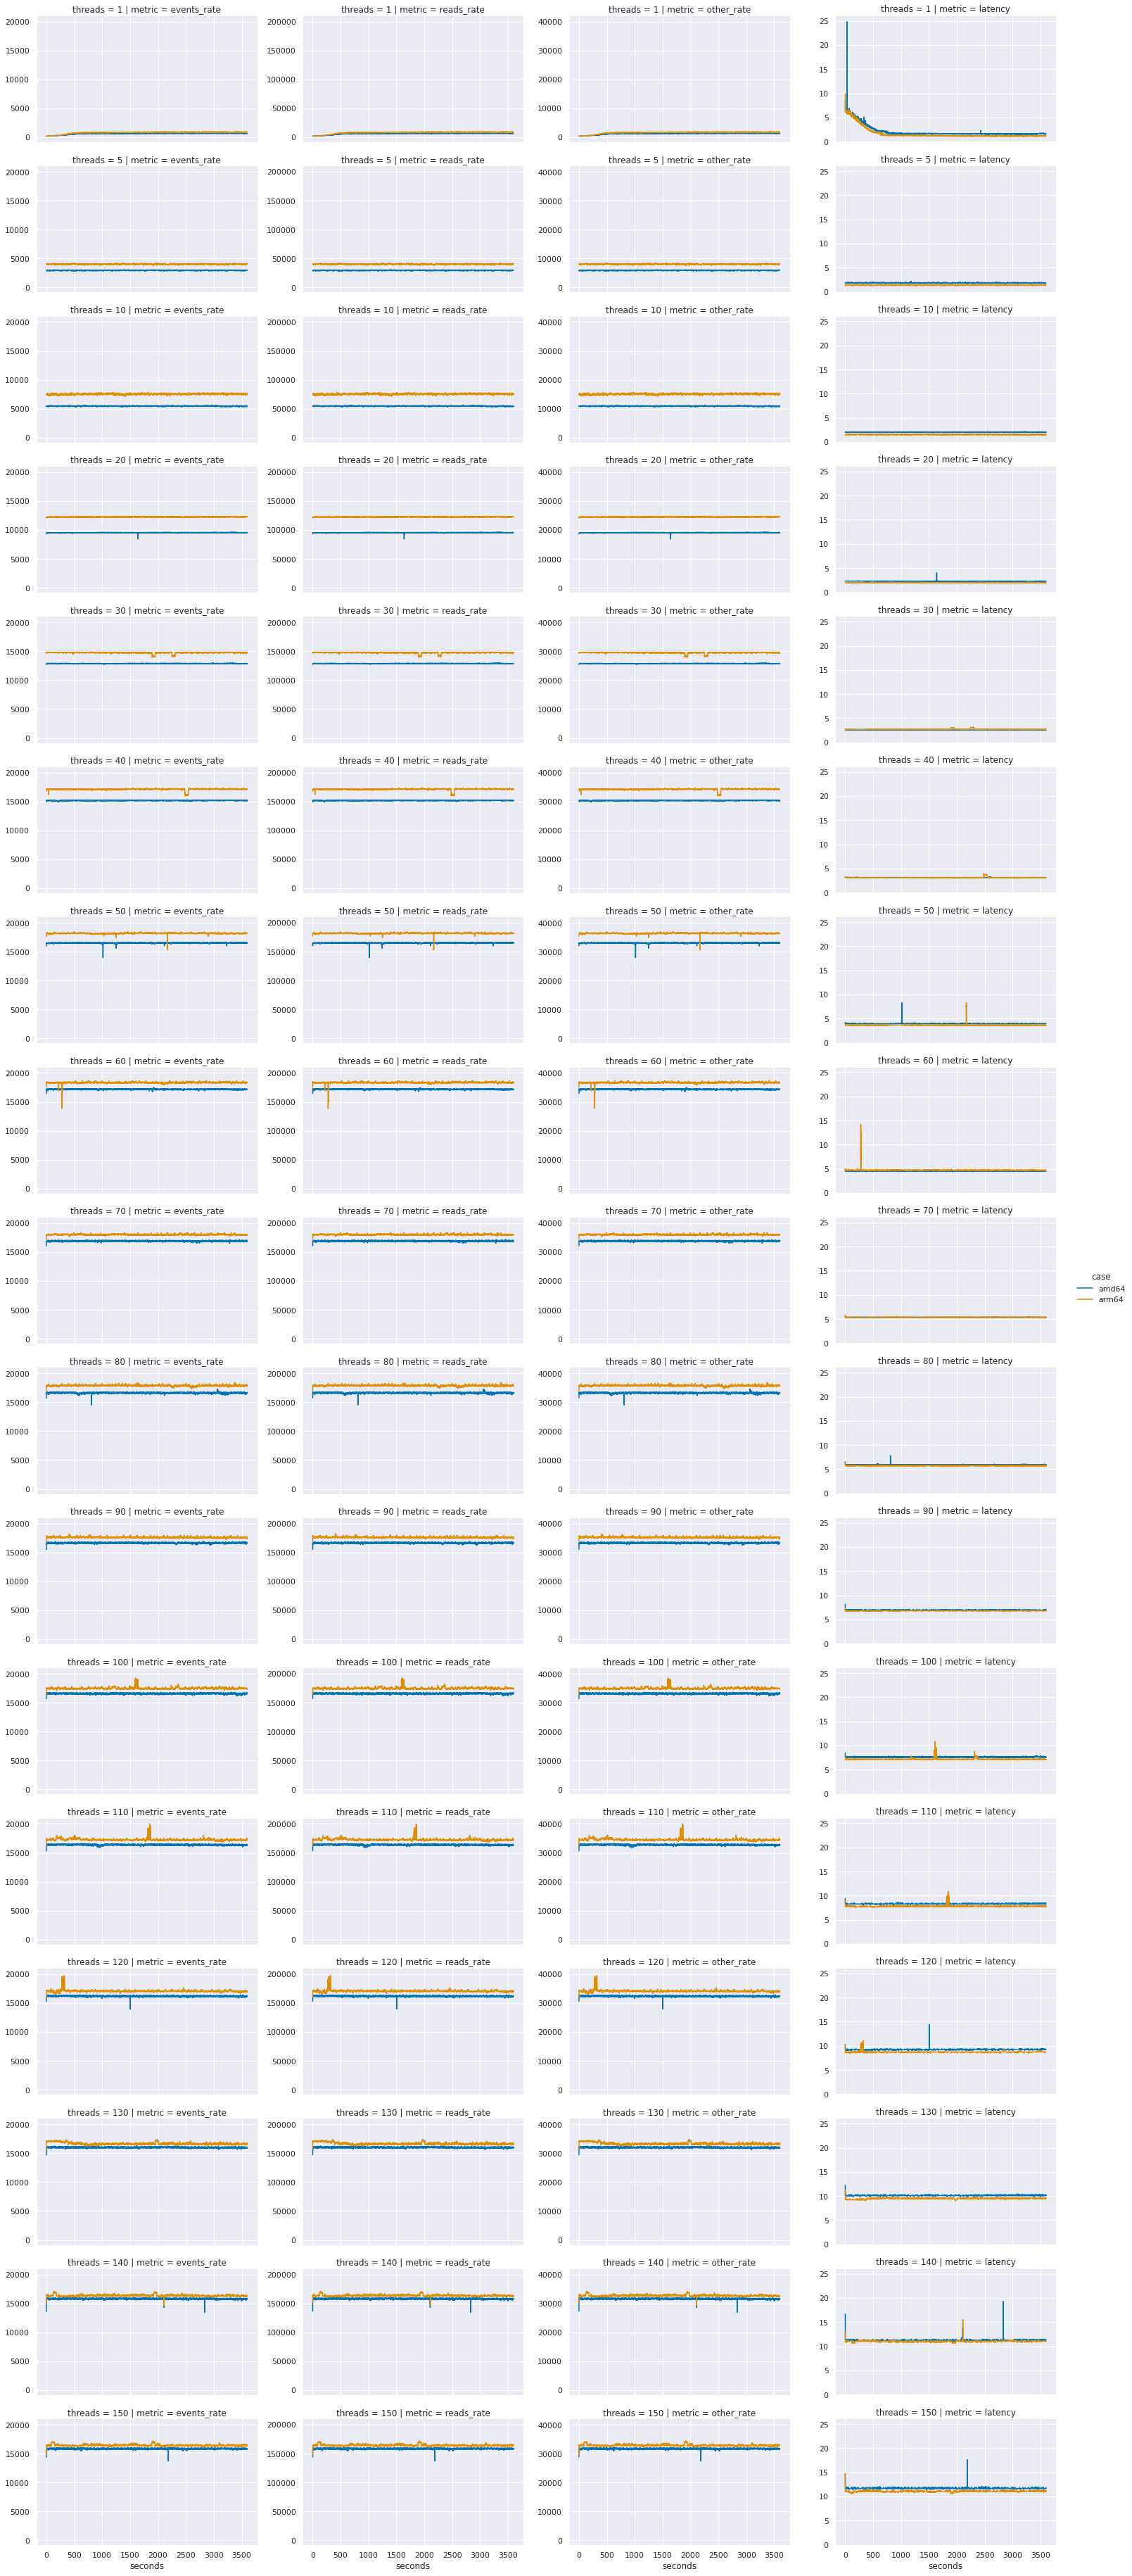

In [26]:
grid = seaborn.relplot(
    data=data,
    kind='line',
    x='seconds', y='value', hue='case', hue_order=hue_order,
    col='metric', row='threads',
    aspect=16/9, height=3,
    facet_kws=dict(sharey='col'),
).set_ylabels('')
grid.tight_layout()

ok, maybe summarize a little

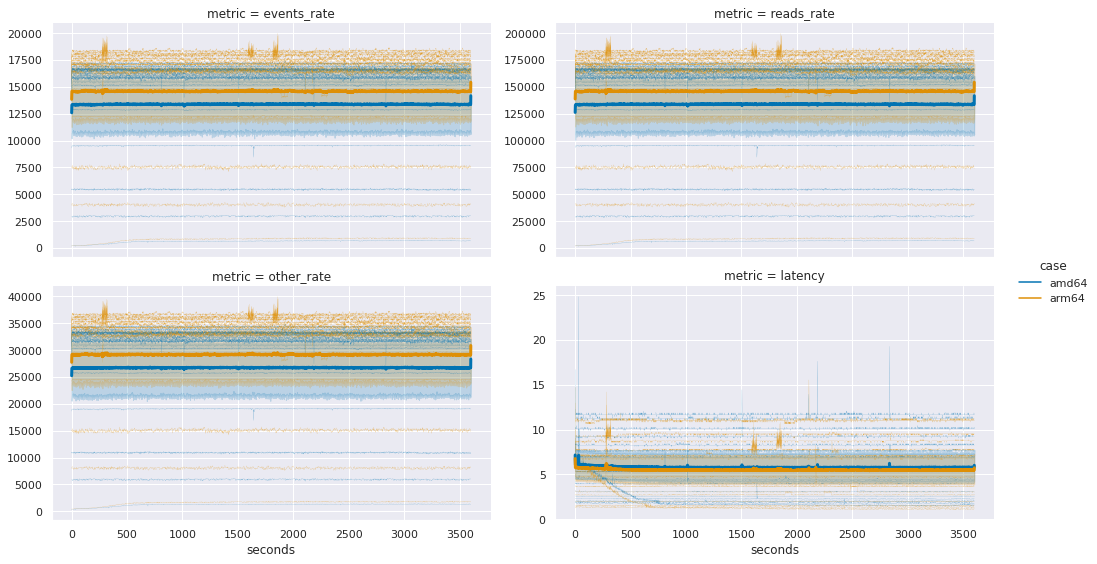

In [27]:
# make a subplot for each metric and plot thin lines
# for each series for that metric there
grid = seaborn.relplot(
    data=data,
    kind='line',
    x='seconds', y='value', hue='case', hue_order=hue_order,
    units='threads',
    col='metric', col_wrap=2,
    estimator=None,
    linewidth=0.1,
    aspect=16/9, height=4,
    facet_kws=dict(sharey=False),
)

# now add a mean and confience intervals
grid.map(
    seaborn.lineplot, 'x', 'y', 'hue', hue_order=hue_order,
    linewidth=3,
)

grid.set_ylabels('')
grid.set_xlabels('seconds')
grid.tight_layout()

And side by side:

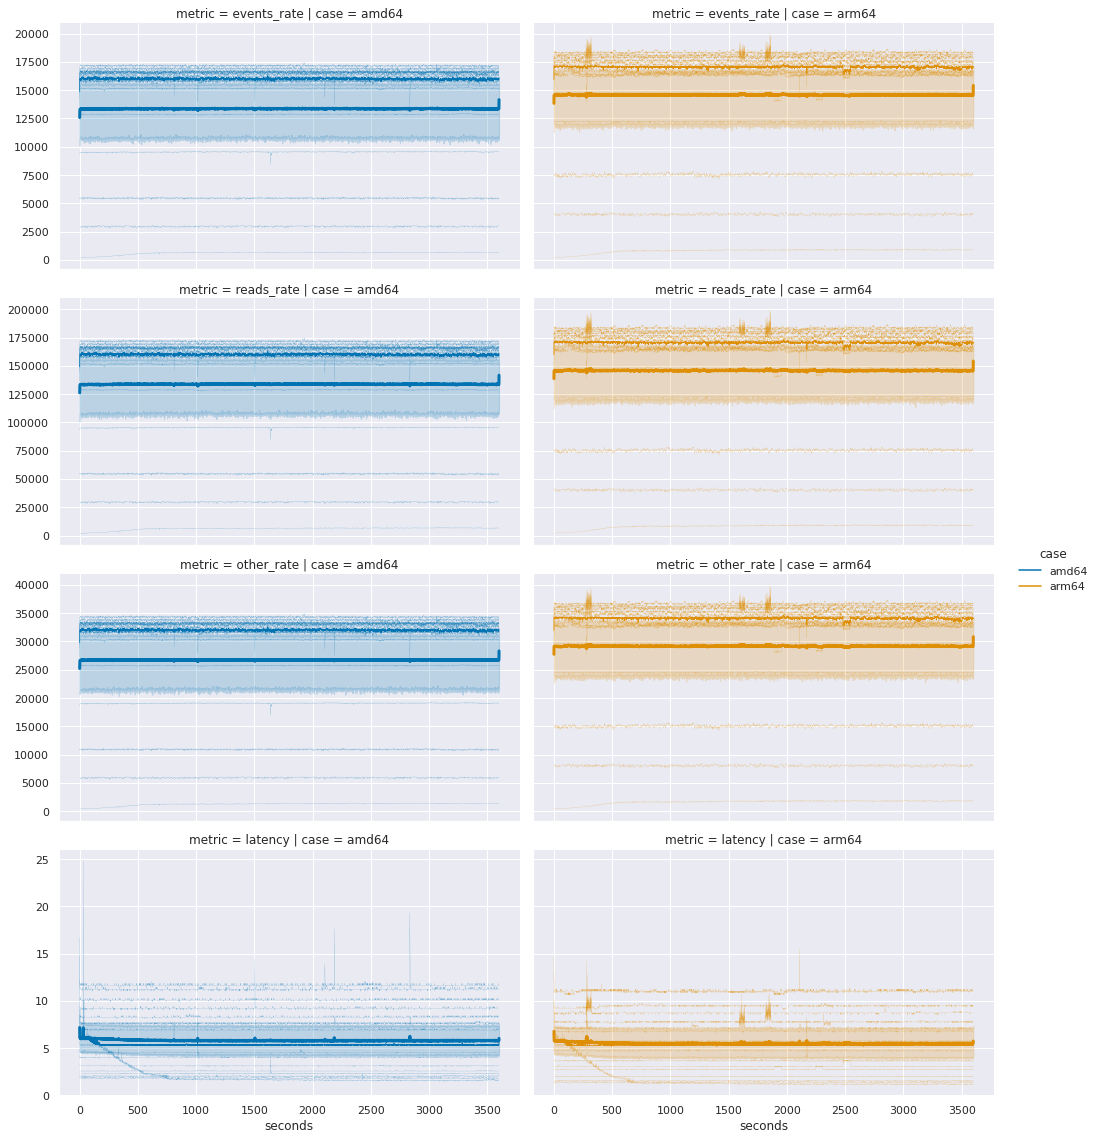

In [28]:
grid = seaborn.relplot(
    data=data,
    kind='line',
    x='seconds', y='value', hue='case', hue_order=hue_order,
    units='threads',
    row='metric', col='case', estimator=None,
    linewidth=0.1,
    aspect=16/9, height=4,
    facet_kws=dict(sharey='row'),
)

grid.map(
    seaborn.lineplot, 'x', 'y', 'case',
    hue_order=hue_order,
    linewidth=3,
)

# also add a median this time
grid.map(
    seaborn.lineplot, 'x', 'y', 'case', 'case',
    hue_order=hue_order,
    estimator=numpy.median, ci=None,
    linewidth=2, dashes=[(1, 2)],
)

grid.set_ylabels('')
grid.set_xlabels('seconds')
grid.tight_layout()

So again, we can see that mean latency is slightly less on ARM and throughput and query rate are slightly higer on ARM. ARM behaves better not only on average, but almost 

# Pairwise metrics plots

Let's quickly look on all pairwise relationships in the dataset:

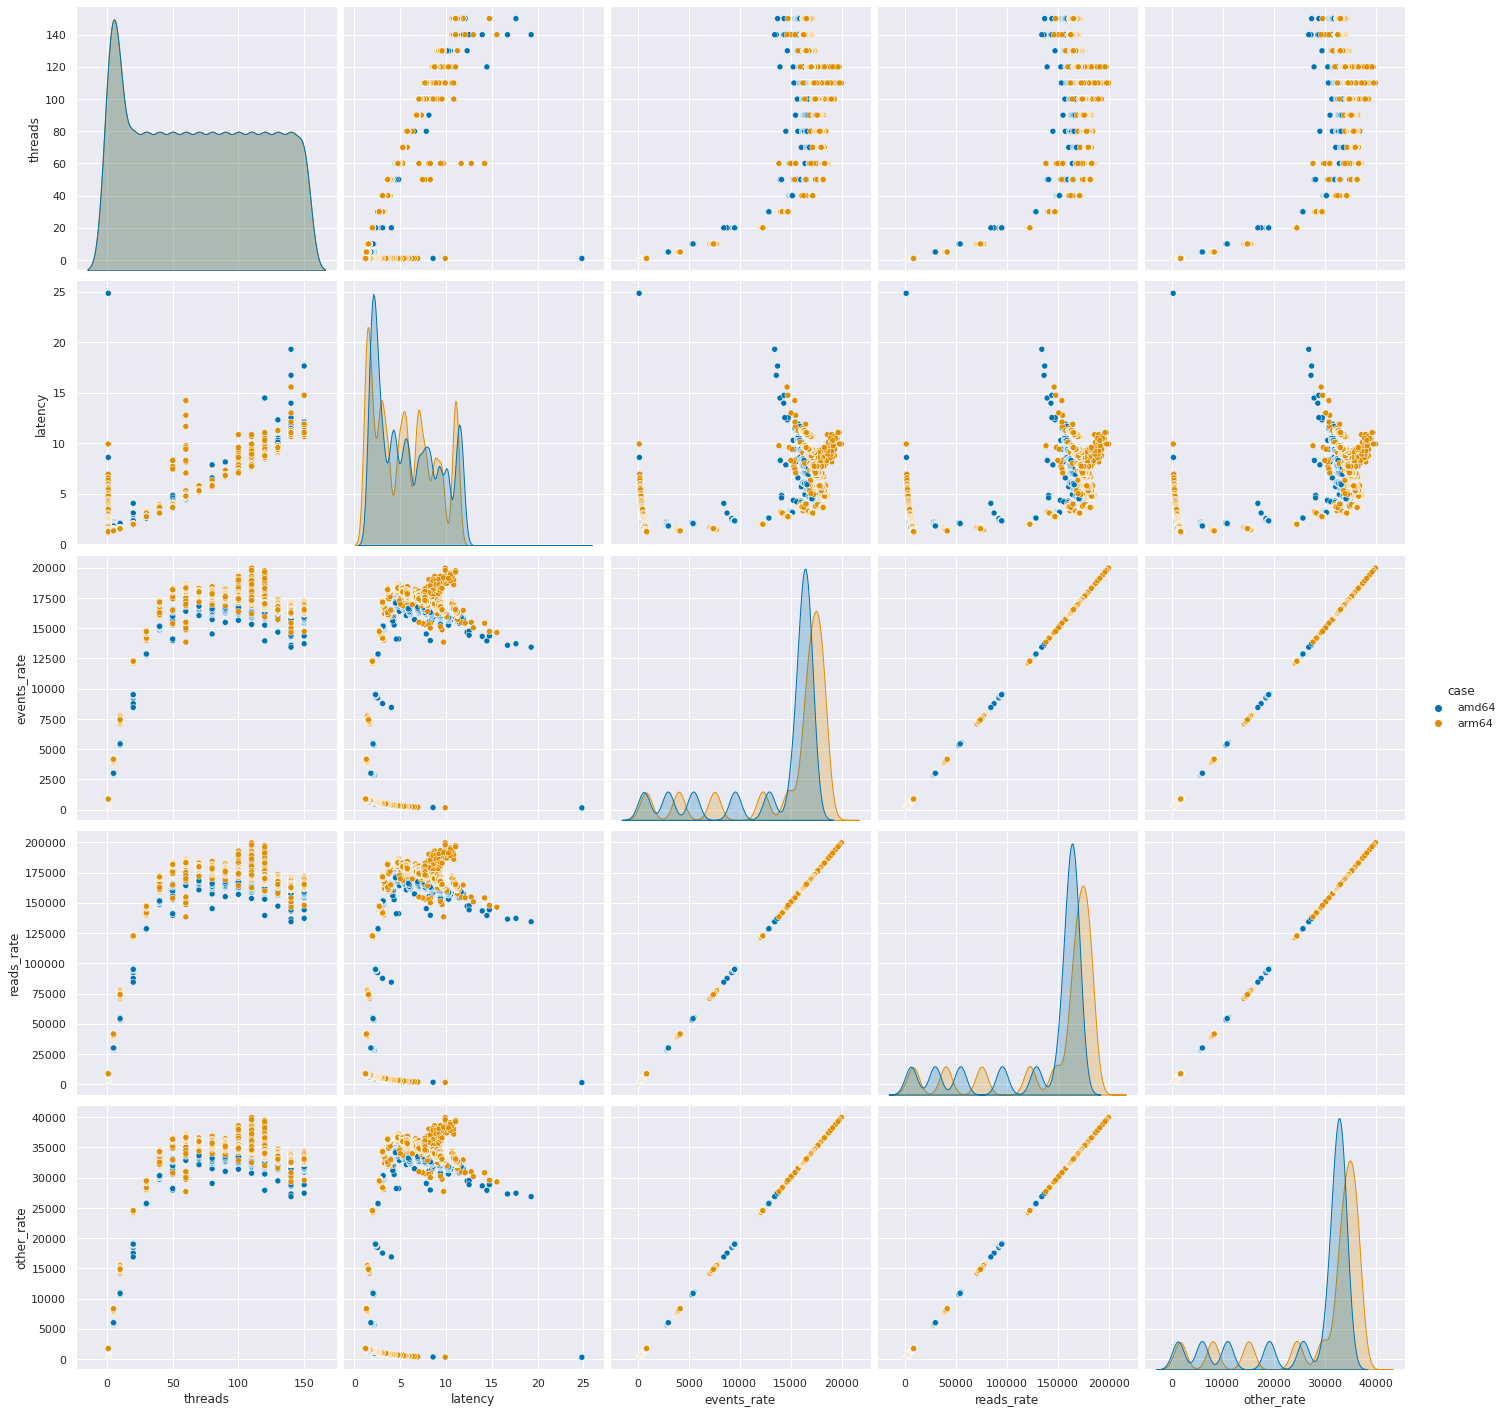

In [29]:
# plot all the numeric time series pairs, density estimation on the diagonal
grid = seaborn.pairplot(
    df[['latency', 'events_rate',
        'reads_rate', 'other_rate'
       ]].reset_index().set_index(['seconds']),
    hue='case', hue_order=hue_order,
    height=4,
)

All the plots have the same shape, so the dynamics of the behaviour is the same, no serious anomalies or extreame performance bursts.

# Threads comparison

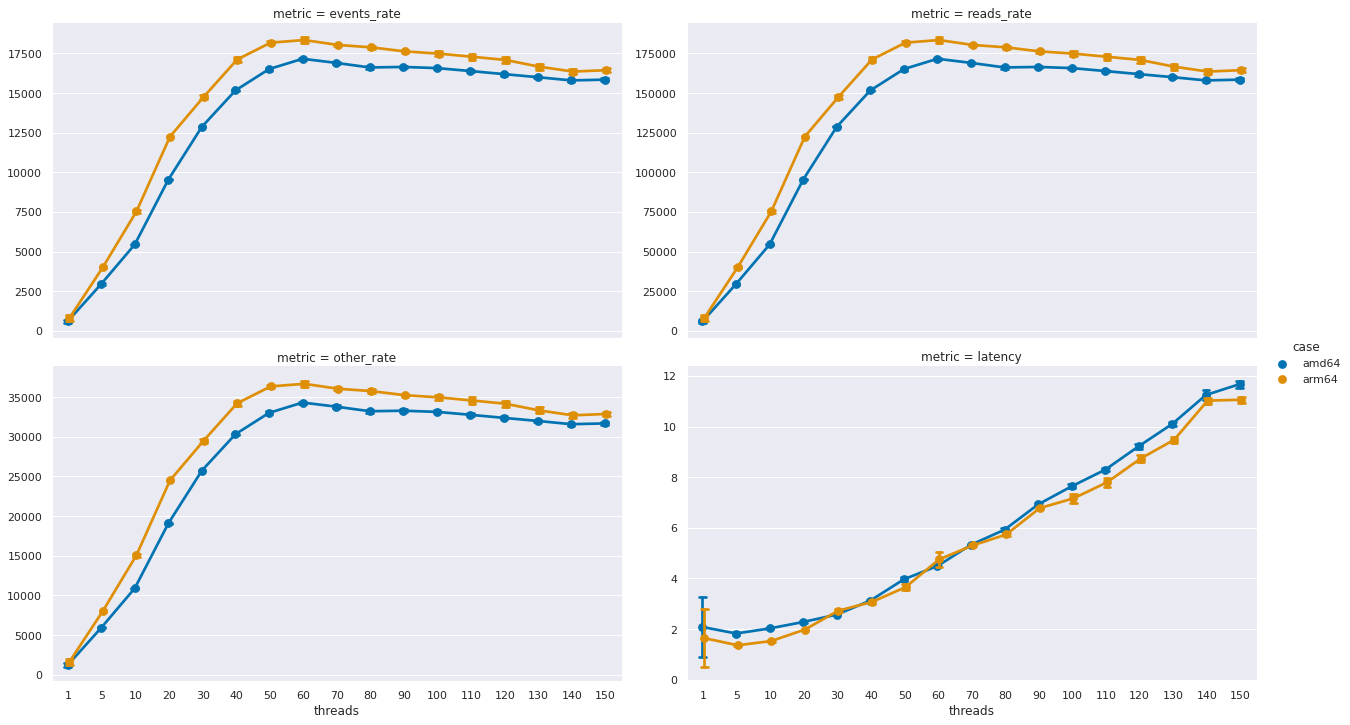

In [30]:
order = data.threads.unique()
hue_order = ('amd64', 'arm64')

grid = seaborn.catplot(
    data=data,

    kind='point', ci='sd', capsize=.2,

    dodge=True,
    x='threads', y='value', orient='v',
    #x='value', y='threads', orient='h',

    hue='case', col='metric', col_wrap=2,
    hue_order=hue_order,
    order=order,

    linewidth=0.5,

    sharey=False,
    aspect=16/9, height=5,
)

grid.set_ylabels('');

Let's take a closer look per thread (threads > 50):

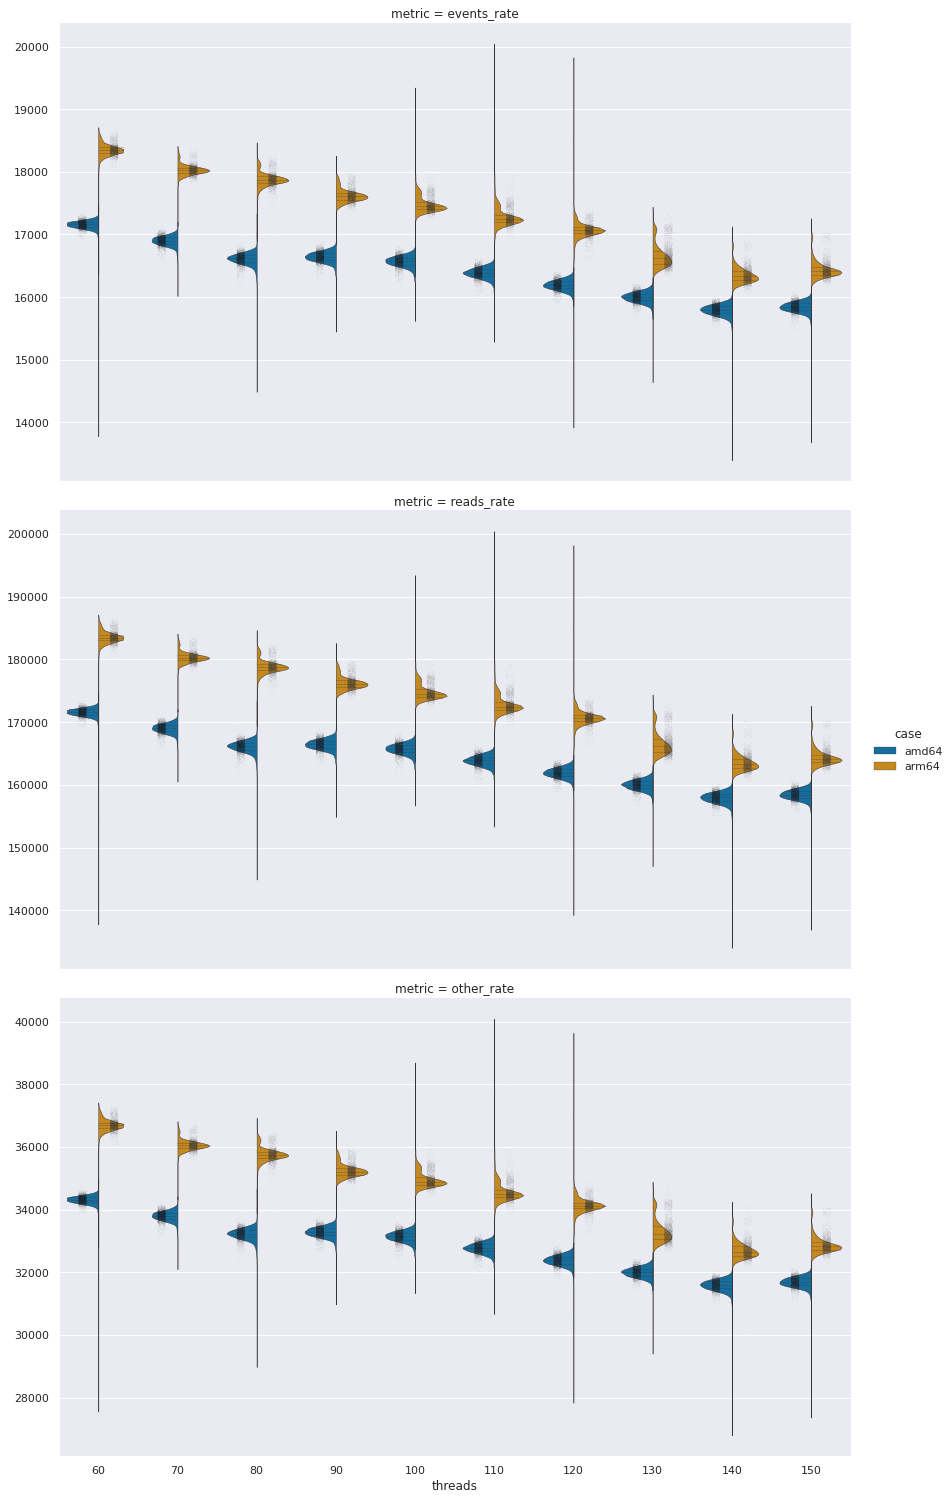

In [31]:
query = 'threads > 50 and metric != "latency"'
order = data.query(query).threads.unique()

grid = seaborn.catplot(
    data=data.query(query),

    kind='violin',
    inner='quartile',

    dodge=True, split=True,
    x='threads', y='value', orient='v',
    #x='value', y='threads', orient='h',

    hue='case', row='metric',
    hue_order=hue_order,
    order=order,

    linewidth=0.5,

    sharey=False,
    aspect=16/9, height=7,
)
grid.map(seaborn.stripplot, 'threads', 'value', 'case', size=0.2,
         color='0.3',
         order=order,
         hue_order=hue_order,
         dodge=True),
grid.set_ylabels('');

# Summary

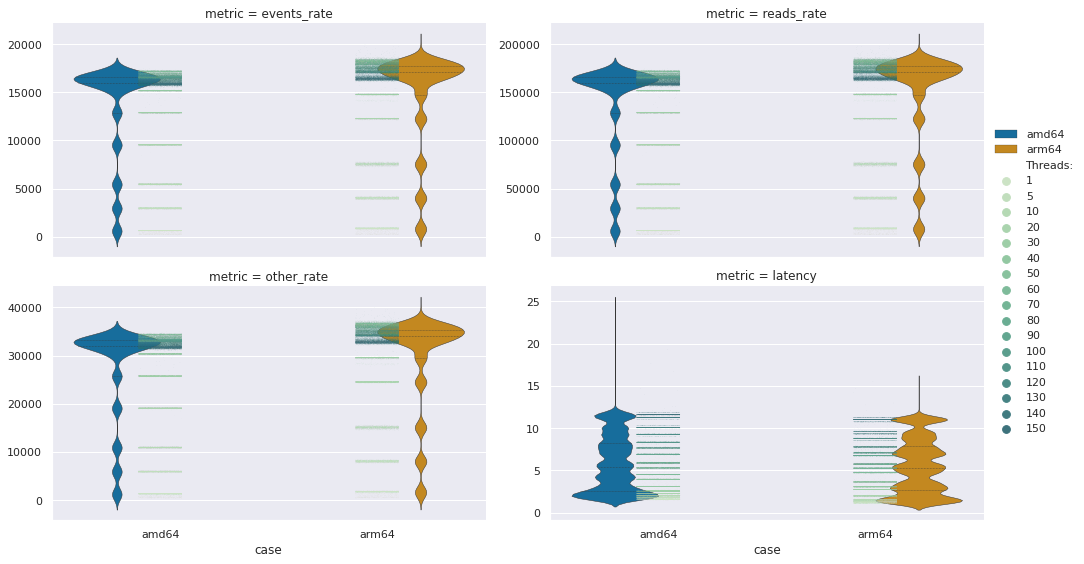

In [32]:
grid = seaborn.catplot(
    data=data,

    kind='violin',
    inner='quartile',

    x='case', y='value', orient='v',

    hue='case', col='metric', col_wrap=2,
    hue_order=hue_order,
    order=hue_order,

    linewidth=0.5,

    sharey=False,
    aspect=16/9, height=4, legend='full',
)
grid.fig.axes[0].plot([], [], ' ', label='Threads:')

grid.map(
    seaborn.stripplot, 'case', 'value', 'threads', size=0.2,
    hue_order=[x for x in df.index.levels if x.name == 'threads'][0],
    palette=seaborn.cubehelix_palette(20, start=0.1, rot=-.5, dark=0.3),
    order=hue_order,
),
grid.set_ylabels('')
grid.add_legend(adjust_subtitles=True);

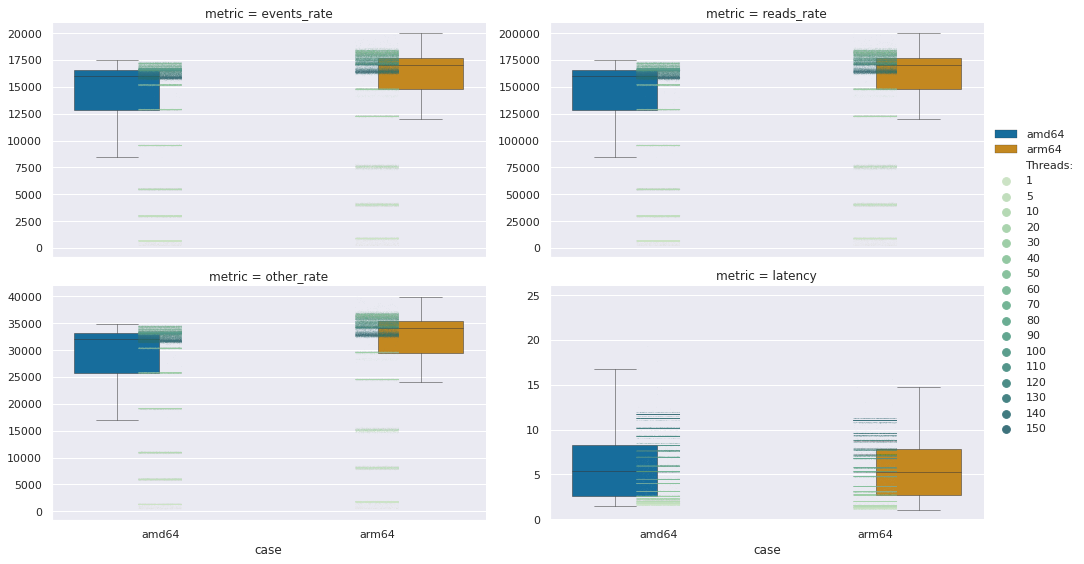

In [33]:
grid = seaborn.catplot(
    data=data,

    kind='box', fliersize=0,

    x='case', y='value', orient='v',
    units='threads',
    hue='case', col='metric', col_wrap=2,
    hue_order=hue_order,
    order=hue_order,

    linewidth=0.5,

    sharey=False,
    aspect=16/9, height=4,
)
grid.fig.axes[0].plot([], [], ' ', label='Threads:')

grid.map(
    seaborn.stripplot, 'case', 'value', 'threads', size=0.2,
     hue_order=[x for x in df.index.levels if x.name == 'threads'][0],
     palette=seaborn.cubehelix_palette(20, start=0.1, rot=-.5, dark=0.3),
     order=hue_order,
),
grid.set_ylabels('')
grid.add_legend(adjust_subtitles=True);

In [34]:
mean_comparison = arm64_to_amd64[columns].mean()
mean_comparison.name = 'arm64'
mean_comparison = mean_comparison.to_frame()
mean_comparison['amd64'] = 1

mean_comparison = mean_comparison * 100

mean_comparison['arm64 improvement'] = mean_comparison['arm64'] - 100

mean_comparison.sort_index(axis=1, ascending=True)

,amd64,arm64,arm64 improvement
metric,,,
events_rate,100,113.362107,13.362107
reads_rate,100,113.362091,13.362091
other_rate,100,113.362100,13.362100
latency,100,92.886919,-7.113081


In [35]:
median_comparison = arm64_to_amd64[columns].median()
median_comparison.name = 'arm64'
median_comparison = median_comparison.to_frame()
median_comparison['amd64'] = 1

median_comparison = median_comparison * 100
median_comparison['arm64 improvement'] = median_comparison['arm64'] - 100

median_comparison.sort_index(axis=1, ascending=True)

,amd64,arm64,arm64 improvement
metric,,,
events_rate,100,107.158958,7.158958
reads_rate,100,107.157223,7.157223
other_rate,100,107.157820,7.157820
latency,100,94.763948,-5.236052
